<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Create-new-features" data-toc-modified-id="Create-new-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create new features</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LabelEncoder" data-toc-modified-id="LabelEncoder-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>LabelEncoder</a></span></li></ul></li></ul></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outliers</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#log-transform-the-target" data-toc-modified-id="log-transform-the-target-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>log-transform the target</a></span></li><li><span><a href="#Normalize-the-data-before-modeling" data-toc-modified-id="Normalize-the-data-before-modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Normalize the data before modeling</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Feature Selection</a></span><ul class="toc-item"><li><span><a href="#Correlation-of-variables-with-target" data-toc-modified-id="Correlation-of-variables-with-target-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Correlation of variables with target</a></span></li><li><span><a href="#nlargest-correlation-matrix" data-toc-modified-id="nlargest-correlation-matrix-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>nlargest correlation matrix</a></span></li><li><span><a href="#statsmodels-for-p-values" data-toc-modified-id="statsmodels-for-p-values-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>statsmodels for p-values</a></span></li><li><span><a href="#Feature-importances" data-toc-modified-id="Feature-importances-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Feature importances</a></span></li><li><span><a href="#Checkpoint:-save-df" data-toc-modified-id="Checkpoint:-save-df-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Checkpoint: save df</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>PCA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [2]:
df = pd.read_pickle('./data/df_wip')
df.shape

(167888, 49)

# Create new features

In [3]:
# Get the trasaction month 
df['N_transaction_month'] = df['transactiondate'].dt.month

# Use the building age instead of year
df['N_building_age'] = [2017 - i for i in df.yearbuilt]

#proportion of living area
df['N_living_area_ratio'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']

#Ratio of the built structure value to land area
df['N_structure_value_ratio'] = df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']

# Quality and Room count
df['N_building_quality_room_cnt']= df['buildingqualitytypeid'] * df['roomcnt'] 

# Location
df['N_location'] = df['latitude'] + df['longitude']

# Quality and location
df['N_building_quality_location']= df['buildingqualitytypeid'] * df['N_location'] 

# Number of properties in the region
region_count = df['regionidcounty'].value_counts().to_dict()
df['N_county_count'] = df['regionidcounty'].map(region_count)

# Ratio of tax of property over parcel
df['N_property_tax_value_ratio'] = df['taxvaluedollarcnt']/df['taxamount']

#Does property have a garage, pool or hot tub and AC
df['N_amenities'] = ((df['garagecarcnt']>0) & (df['pooltypeid10']>0) & (df['airconditioningtypeid']!=5))*1 

# Length of time since unpaid taxes
# df['N_unpaid_taxes_length'] = [2017 - i for i in df.taxdelinquencyyear]

#There's 25 different property uses - let's compress them down to 4 categories
df['N_property_uses_Type'] = df.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })

### LabelEncoder

In [4]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df['propertycountylandusecode'])
df['propertycountylandusecode'] = le.transform(df['propertycountylandusecode'])

le.fit(df['N_property_uses_Type'])
df['N_property_uses_Type'] = le.transform(df['N_property_uses_Type'])

# Outliers

In [5]:
df['logerror'].describe()

count    167888.000000
mean          0.013906
std           0.165706
min          -4.655420
25%          -0.025300
50%           0.006000
75%           0.039200
max           5.262999
Name: logerror, dtype: float64

In [6]:
df = df[df['logerror'] <  df['logerror'].quantile(0.9975)]  # exclude 0.5% of outliers
df = df[df['logerror'] >  df['logerror'].quantile(0.0025)]

In [7]:
# Number of records after dropping outliers
df.shape

(167046, 60)

# Feature Engineering

In [8]:
# Separating out the features
features = df.columns.drop(['logerror','transactiondate','parcelid'])

X = df.drop(columns=['logerror','transactiondate','parcelid'], axis=1).values

# Separating out the target
y = df['logerror'].values

# log-transform the target

[Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [9]:
y_trans = np.log1p(y)

# Normalize the data before modeling

In [10]:
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [11]:
print(X.shape)
print(y_trans.shape)

(167046, 57)
(167046,)


# Feature Selection 

## Correlation of variables with target

In [12]:
# Calculate correlation coefficient between (all properties and target column logerror).
# Select columns except logerror and which are float64
colNames = [colName for colName in df.columns if colName not in ['logerror'] if df[colName].dtype=='float64']

# Calculate correlation of colNames with logerror
corrValues = []
for col in colNames:
    corrValues.append(np.corrcoef(df[col].values, df['logerror'].values)[0,1]) # np.corref returns correlation matrix
corrDF = pd.DataFrame({'colNames':colNames, 'corrValues':corrValues})
corrDF = corrDF.sort_values(by='corrValues')
pd.DataFrame(corrDF)

,colNames,corrValues
16,poolcnt,-0.022340
17,poolsizesum,-0.022280
20,pooltypeid7,-0.020551
39,taxamount,-0.011308
42,N_building_age,-0.008812
25,regionidcounty,-0.008152
19,pooltypeid2,-0.007796
22,propertyzoningdesc,-0.007296
21,propertylandusetypeid,-0.005086
38,landtaxvaluedollarcnt,-0.004813


## nlargest correlation matrix 

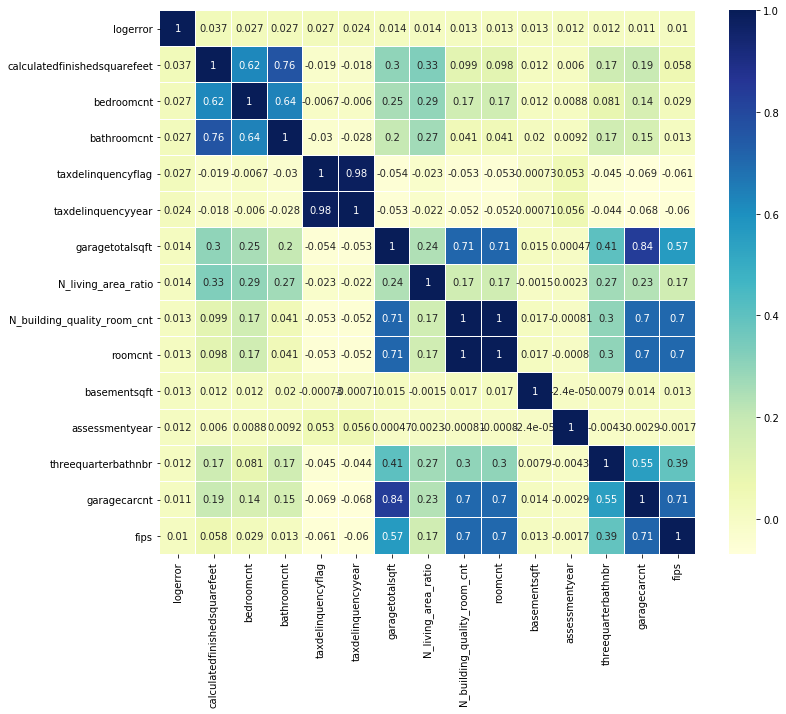

In [13]:
# Target correlation matrix 
# k : number of variables for heatmap 

corrmat = df.corr() 
k = 15 
  
cols = corrmat.nlargest(k, 'logerror')['logerror'].index 
  
cm = np.corrcoef(df[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", annot=True,
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 

## statsmodels for p-values

In [14]:
# linear regression in statsmodels
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import statsmodels.api as sm

# add a constant to X, which create a np.ones
X_added = add_constant(X)  

# OLS fit model
lr_model = OLS(y_trans,X_added)
results = lr_model.fit()

# parameters
parameters = results.params

# get y_pred
y_pred = results.predict(X_added)

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     31.45
Date:                Wed, 10 Jul 2019   Prob (F-statistic):          2.02e-312
Time:                        20:22:52   Log-Likelihood:             1.3165e+05
No. Observations:              167046   AIC:                        -2.632e+05
Df Residuals:                  166992   BIC:                        -2.626e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.000     23.926      0.000       0.006       0.007
x1             0.0001      0.000      0.351      0.726      -0.001       0.001
x2            -0.0006      0.000     -1.927      0.054      -0.001    1.08e-05
x3             0.0013      0.000      4.726      0.000       0.001       0.002
x4             0.0007      0.001      1.397      0.163      -0.000       0.002
x5             0.0005      0.000      1.147      0.251      -0.000       0.001
x6             0.0832      0.083      1.001      0.317      -0.080       0.246
x7             0.0088      0.001     15.291      0.000       0.008       0.010
x8            -0.0014      0.000     -4.251      0.000      -0.002      -0.001
x9             0.1131      0.026      4.327      0.000       0.062       0.164
x10           -0.0012      0.000     -2.971      0.003      -0.002      -0.000
x11           -0.0020      0.001     -2.313      0.021      -0.004      -0.000
x12            0.0007      0.001      1.072      0.284      -0.001       0.002
x13            0.0011      0.001      1.024      0.306      -0.001       0.003
x14           -0.0006      0.001     -0.938      0.348      -0.002       0.001
x15           -0.0013      0.000     -2.711      0.007      -0.002      -0.000
x16            0.0008      0.001      1.469      0.142      -0.000       0.002
x17            0.0012      0.000      4.180      0.000       0.001       0.002
x18           -0.0195      0.010     -1.864      0.062      -0.040       0.001
x19           -0.0010      0.003     -0.284      0.777      -0.008       0.006
x20           -0.0012      0.001     -1.611      0.107      -0.003       0.000
x21            0.0025      0.002      1.224      0.221      -0.001       0.006
x22            0.0165      0.010      1.712      0.087      -0.002       0.035
x23           -0.0069      0.001     -5.078      0.000      -0.010      -0.004
x24            0.0013      0.000      3.627      0.000       0.001       0.002
x25           -0.0002      0.000     -0.566      0.571      -0.001       0.000
x26           -0.1369      0.032     -4.215      0.000      -0.200      -0.073
x27            0.0004      0.000      1.390      0.164      -0.000       0.001
x28            0.0251      0.006      3.873      0.000       0.012       0.038
x29            0.0002      0.000      0.616      0.538      -0.000       0.001
x30           -0.0005      0.000     -1.934      0.053      -0.001    7.16e-06
x31           -0.0430      0.104     -0.415      0.678      -0.246       0.160
x32            0.0008      0.000      2.159      0.031    7.05e-05       0.001
x33           -0.0006      0.000     -2.180      0.029      -0.001    -6.4e-05
x34           -0.0008      0.000     -2.548      0.011      -0.001      -0.000
x35           -0.0004      0.000     -1.433      0.152      -0.001       0.000
x3

## Feature importances

In [16]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X,y_trans)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = features,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
N_property_tax_value_ratio,0.063469
calculatedfinishedsquarefeet,0.060108
structuretaxvaluedollarcnt,0.056046
N_structure_value_ratio,0.055093
N_living_area_ratio,0.054660
latitude,0.051205
N_building_quality_location,0.049097
lotsizesquarefeet,0.048606
taxamount,0.047983
longitude,0.046962


## Checkpoint: save df

In [19]:
# Separating out the features to minimze noises by low value of features of importance from EDA
df = df.drop(['N_amenities','pooltypeid10','pooltypeid2','fireplaceflag',
             'taxdelinquencyflag','taxdelinquencyyear'],axis=1)

df.to_pickle('./data/df_wip2')

In [ ]:
--

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

In [ ]:
np.cumsum(pca.explained_variance_ratio_ )